In [234]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from motion_planning_utils import *
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper
# from pyscipopt import *
from gurobipy import *
import json


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(5.5, 5.5)


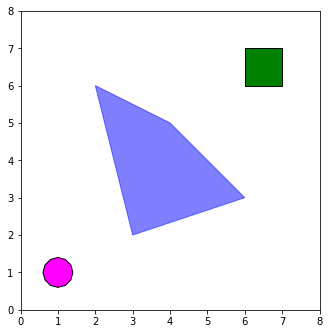

In [262]:
# Sample Problem
obstacles = [(3,2), (2,6), (4,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In [334]:
start = (3.1,0)
goal = [(3.1,6),(2.9,6),(2.9,5.8),(3.1,5.8)]
N = 30
timestep = 1
V_max = 1
buffer = 1e-4
bounds = (0, 0, 8, 8)

# obs_list = [[(3,2), (2,6), (4,5), (6,3)]]
# obs_list = [[(1,3), (5,2), (4,3)], [(3,6), (3,4), (7,3)]]
# obs_list = buff_obs
# obs_list = [[(1,3), (5,2), (4,3)], [(3,6), (3,4), (7,3)]]
obs_list = [[(1,1), (1,3), (3,3), (3,1)], 
            [(1,3), (1,5), (3,5), (3,3)],
            [(3,1), (3,3), (5,3), (5,1)],
            [(3,3), (3,5), (5,5), (5,3)]]


m, x, y = create_model(start, goal, obs_list, bounds, N, timestep, V_max, buffer)

In [335]:
m.optimize()

Optimize a model with 618 rows, 542 columns and 1458 nonzeros
Model has 122 quadratic objective terms
Model has 30 quadratic constraints
Variable types: 62 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 6e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 38 rows and 18 columns
Presolve time: 0.01s
Presolved: 580 rows, 524 columns, 1392 nonzeros
Presolved model has 118 quadratic objective terms
Variable types: 60 continuous, 464 integer (464 binary)

Root relaxation: objective 1.121372e+00, 774 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.12137    0  316          -    1.12137      -     -    0s
     0     0    1.12137    0  13

(5.5, 5.5)
Obstacle Vertices: 
 [[(1, 1), (1, 3), (3, 3), (3, 1)], [(1, 3), (1, 5), (3, 5), (3, 3)], [(3, 1), (3, 3), (5, 3), (5, 1)], [(3, 3), (3, 5), (5, 5), (5, 3)]]


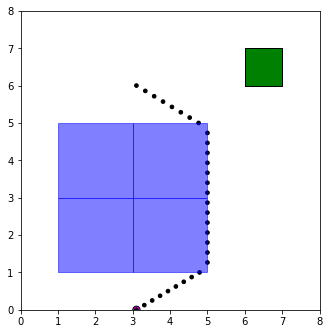

In [280]:
path_list = []
for t in range(len(x)):
    path_list.append((x[t].x, y[t].x))

##### Redefine obstacles with radius of droid; treat droid as a point robot
goal = [(6,6), (6,7), (7,7), (7, 6)]
ax = plot_env(obs_list, start, goal, bounds, Environment(None))

for pt in path_list:
    t_pt = Point(pt).buffer(0.05, resolution=3)
    plot_poly(ax, t_pt, 'black')    


print('Obstacle Vertices: \n', obs_list)



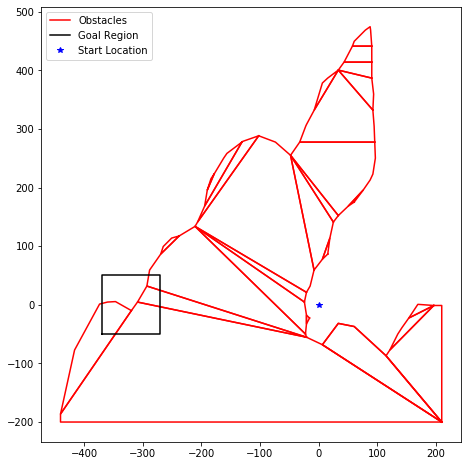

In [269]:
# Test JSON obstacle file

with open('notamoon.json') as f:
    ex_json_dict = json.load(f)
plt.figure(figsize=(14,8))

for obs in ex_json_dict['obstacles']:
    coord = np.array(obs['geometry']['coordinates'])
    plt.plot(coord[:,0],coord[:,1],'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')


In [325]:
obs_list_nm = process_json_obstacles(ex_json_dict, remove_duplicates=True)
obs_list_nmd = process_json_obstacles(ex_json_dict)

goal_region = ex_json_dict['goal']['geometry']['coordinates'][:-1]

# Test
print(obs_list_nm[0])
print(obs_list_nmd[0])

[[-130.7946541999172, 277.4456521740021], [-156.42857142807998, 258.12137356524545], [-161.85781839936908, 250.1630434784019], [-178.26184727596228, 222.88043478280173], [-189.85758822651633, 195.59782608702392], [-194.3786565504979, 168.31521739142374]]
[[-130.7946541999172, 277.4456521740021], [-156.42857142807998, 258.12137356524545], [-161.85781839936908, 250.1630434784019], [-178.26184727596228, 222.88043478280173], [-189.85758822651633, 195.59782608702392], [-194.3786565504979, 168.31521739142374], [-130.7946541999172, 277.4456521740021]]


In [331]:
start = (0,0)
# goal = (-350,50)
# goal = (-10,300)
# goal = (100, 100)
goal = goal_region
bounds = (-500, -250, 250, 500)
N = 6
timestep = 2
V_max = 100
buffer = 10
# obs_list = obs_list_nm[19:23] + obs_list_nm[0:10]
# obs_list = obs_list_nm[15:16]
obs_list = obs_list_nm

m, x, y = create_model(start, goal, obs_list, bounds, N, timestep, V_max, buffer)
m.optimize()

Optimize a model with 1058 rows, 800 columns and 3182 nonzeros
Model has 26 quadratic objective terms
Model has 6 quadratic constraints
Variable types: 14 continuous, 786 integer (786 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+06]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e+00, 7e+04]
  QRHS range       [4e+04, 4e+04]
Presolve removed 305 rows and 171 columns
Presolve time: 0.02s
Presolved: 753 rows, 629 columns, 2426 nonzeros
Presolved model has 22 quadratic objective terms
Variable types: 12 continuous, 617 integer (617 binary)

Root relaxation: objective 1.306667e+04, 1223 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13066.6667    0  393          - 13066.6667      -     -    0s
     0     0 13079.0304    0  3

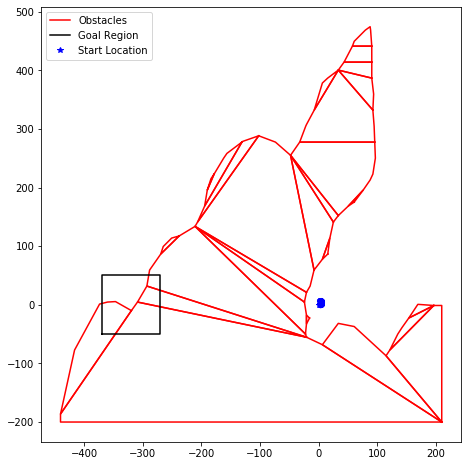

In [336]:
path_list = []
for t in range(1,len(x)):
    path_list.append((x[t].x, y[t].x))

plt.figure(figsize=(14,8))
for obs in obs_list_nmd:
    xcoords = [obs[c][0] for c in range(len(obs))]
    ycoords = [obs[c][1] for c in range(len(obs))]
    plt.plot(xcoords,ycoords,'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
# line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')

for pt in path_list:
    plt.scatter(pt[0], pt[1], linestyle='--', marker='o', color='b')

In [304]:
obs_list_nm[22]

[[-20.714285714973357, -55.31198025110484],
 [-22.41934091529174, -49.945652173732924],
 [-210.71428571417528, 133.68808198936932],
 [-237.85714285793347, 117.32852606520794],
 [-269.25829396162726, 86.46739130444558],
 [-288.26572832940656, 59.18478260884541],
 [-292.8777215842615, 31.9021739130676]]

(5.5, 5.5)


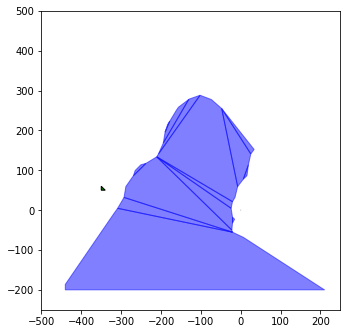

In [305]:
goal = [goal, (goal[0]+10, goal[1]), (goal[0], goal[1]+10)]
ax = plot_env(obs_list, start, goal, bounds, Environment(None))

In [230]:
m.write("grb_test_model.lp")

In [134]:
path_list

[(-6.571428571657786, 40.72070801347564),
 (-13.142857143315572, 81.44141602695127),
 (-19.714285714973357, 122.16212404042692),
 (-27.8188842850499, 162.88283205390258),
 (-36.14330620275413, 203.5585524857549),
 (-44.467728120458354, 244.23427291760717),
 (-76.76977703675226, 280.0028919729515),
 (-121.82699388833592, 281.9490296376335),
 (-157.26383488651481, 256.43119710508734),
 (-186.62956717021936, 226.7715976138022),
 (-215.99529945392393, 197.11199812251706),
 (-245.36103173762848, 167.45239863123194),
 (-274.0247905726376, 138.51259091663093),
 (-299.3498603817584, 109.00839394442062),
 (-324.6749301908792, 79.50419697221031),
 (-350.0, 50.0)]

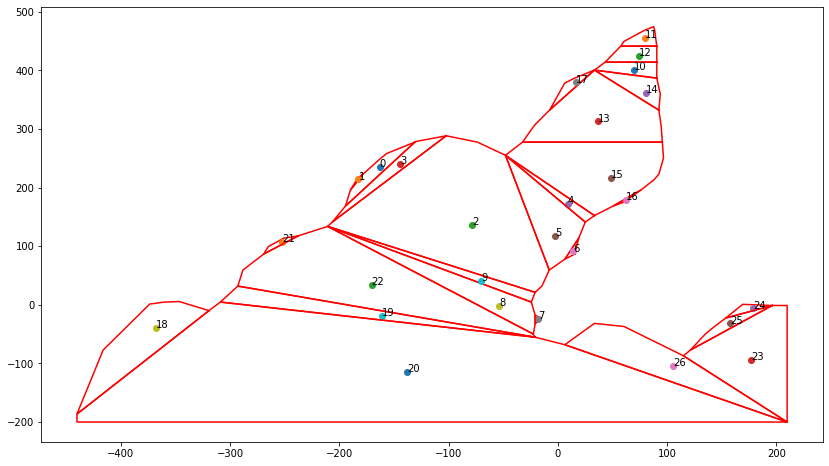

In [194]:
plt.figure(figsize=(14,8))
for idx, obs in enumerate(obs_list_nm):
    xcoords = [obs[c][0] for c in range(len(obs))]
    ycoords = [obs[c][1] for c in range(len(obs))]
    cent = find_vertex_avg(obs)
    plt.plot(xcoords,ycoords,'-r')
    plt.plot(cent[0], cent[1], 'o')
    plt.annotate(idx, (cent[0], cent[1]))
    

# for obs in ex_json_dict['obstacles'][1:14]:
#     coord = np.array(obs['geometry']['coordinates'])
#     plt.plot(coord[:,0],coord[:,1],'-r')
#     cent = find_vertex_avg(coord)
#     plt.plot(cent[0], cent[1], 'o')
#     print(cent)
#     plt.show()

In [115]:
# start_point = (0,0)
# goal_state = (-350,50)
# N = 8
# timestep = 4
# T = int(N * timestep)
# time = list(range(1,N+1))
# V_max = 100
# M = 1e6
# eps = .1
# # TODO - automate bounds creation
# bounds = (-550, -300, 300, 550)
# # obs_list = [[(3,2), (2,6), (4,5), (6,3)]]
# obs_list = obs_list_nm

# model = Model()

# # Set x,y decision vars
# x,y,z = {},{},{}
# for t in range(0,N+1):
#     x[t] = model.addVar(lb=bounds[0], ub=bounds[2], name="x(%s)"%(t))
#     y[t] = model.addVar(lb=bounds[1], ub=bounds[3], name="y(%s)"%(t))
        
# # Set objective function
# model.setObjective(quicksum((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) for t in time))

# # Set initial conditions
# model.addConstr(x[0] == start_point[0])
# model.addConstr(y[0] == start_point[1])

# # Set velocity constraint for each time period
# for t in time:
#     model.addQConstr((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) <= V_max**2 * timestep**2)
    
# # Set goal state conditions
# model.addConstr(x[N] == goal_state[0])
# model.addConstr(y[N] == goal_state[1])
    
# # Set Obstacle Constraints
# for idx_obs, obs in enumerate(obs_list):
#     # create z variables z_obs_len(obs)
    
#     for idx_v, vertex, in enumerate(obs):
#         for t in time:
#             z[(idx_obs, idx_v, t)] = model.addVar(name="z(%s,%s,%s)"%(idx_obs,idx_v,t), vtype="BINARY")
#         vertex1 = obs[idx_v]
#         vertex2 = obs[(idx_v + 1)%len(obs)] # grab next vertex and loop back to the first for last index
#         delta_x = vertex2[0] - vertex1[0]
#         delta_y = vertex2[1] - vertex1[1]
#         vertex_avg = find_vertex_avg(obs) # known that avg of vertices lies inside convex polygon
#         if delta_x != 0:  # check if line is vertical
#             m = delta_y / delta_x
#             b = vertex1[1] - m * vertex1[0]
#             if vertex_avg[1] < m * vertex_avg[0] + b:  # then flip constraint
#                 model.addConstrs(-y[t] <= -m * x[t] - b + M*z[(idx_obs, idx_v, t)] - eps for t in time)
#             else:
#                 model.addConstrs(y[t] <= m * x[t] + b + M*z[(idx_obs, idx_v, t)] - eps for t in time)
#         else:
#             if vertex_avg[0] <= vertex1[0]:  # then flip constraint
#                 model.addConstrs(-x[t] <= -vertex1[0] + M*z[(idx_obs, idx_v, t)] - eps for t in time)
#             else:
#                 model.addConstrs(x[t] <= vertex1[0] + M*z[(idx_obs, idx_v, t)] - eps for t in time)
#     for t in time:            
#         model.addConstr(quicksum(z[(idx_obs,v,t)] for v in range(len(obs))) <= (len(obs) - 1))

# model.update()
# model.optimize()